In [1]:
using Distributions, Random, Plots, CurveFit, LinearAlgebra, Richardson
Random.seed!(123)

TaskLocalRNG()

In [2]:
global const diffusivity = 1.00::Float64

global const endtime = 1.00::Float64
global const L = 1.00::Float64

global const dt = 1e-4::Float64
global const timesteps = Int64(div(endtime,dt)+1)::Int64

global const spacesteps = 150::Int64

global const u0 = 1::Int64
global const u0_tilda = (u0*L/spacesteps)::Float64

global const cfl = (diffusivity*(spacesteps*spacesteps)*dt/L^2)::Float64

##########################################################################

global const D_left = 1.0::Float64
global const D_right = 2.0::Float64





2.0

### Diffusion equation 
$$\frac{\partial u}{\partial t} = \frac{\partial}{\partial x} \left( D\frac{\partial u}{\partial x}\right)$$

In [4]:
function Crank_Nicolson_step(A::Tridiagonal{Float64, Vector{Float64}}, B::Tridiagonal{Float64, Vector{Float64}}, u_inint::Vector{Float64})
    return A\(B*u_inint)
end

function CN_absorbing_BC(u_init::Vector{Float64}, alpha::Float64)
    #A * U_n+1 = B * U_n
    n_steps = spacesteps-2

    A = Tridiagonal(fill(-alpha/2, n_steps-1),
                    fill(1+alpha, n_steps),
                    fill(-alpha/2, n_steps-1))

    B = Tridiagonal(fill(alpha/2, n_steps-1),
                    fill(1-alpha, n_steps),
                    fill(alpha/2, n_steps-1))


    res = Array{Array{Float64, 1}, 1}(undef, timesteps)
    res[1] = u_init
    for n in 1:timesteps-1
        res[n+1] = reduce(vcat, [0, Crank_Nicolson_step(A,B,res[n][2:end-1]),0])
    end
    return res
end 

function CN_reflecting_BC(u_init::Vector{Float64}, alpha::Float64)
    #A * U_n+1 = B * U_n
    n_steps = size(u_init,1)

    A = Tridiagonal(reduce(vcat, [fill(-alpha/2, n_steps-2), -alpha]),
                        fill(1+alpha, n_steps),
                        reduce(vcat, [-alpha, fill(-alpha/2, n_steps-2)]))
    
    B = Tridiagonal(reduce(vcat, [fill(alpha/2, n_steps-2), alpha]),
                        fill(1-alpha, n_steps),
                        reduce(vcat, [alpha, fill(alpha/2, n_steps-2)]))

    res = Array{Array{Float64, 1}, 1}(undef, timesteps)
    res[1] = u_init
    for n in 1:timesteps-1
        res[n+1] = Crank_Nicolson_step(A,B,res[n])
    end
    return res
end



CN_reflecting_BC (generic function with 1 method)

In [5]:
function absorbing_bounds(x0::Float64, x::Float64, t::Float64; max_iter = 1000, tol = 1e-8)
    res = 0
    term = 1 
    for n in 1:max_iter
        vn_x0 = sqrt(2/L) * sin(n * pi * x0/L)
        vn_x = sqrt(2/L) * sin(n * pi * x/L)
        term = exp(-((n * pi/L)^2) * diffusivity * t) * vn_x0 * vn_x
        res += term
        if tol > abs(term) && abs(term) > 1e-15
            break
        end
    end
    return u0_tilda * res
end

function reflecting_bounds(x0::Float64, x::Float64, t::Float64; max_iter = 1000, tol = 1e-8)
    res = 1/L
    term = 1 
    for n in 1:max_iter
        vn_x0 = sqrt(2/L) * cos(n * pi * x0/L)
        vn_x = sqrt(2/L) * cos(n * pi * x/L)
        term = exp(-((n * pi/L)^2) * diffusivity * t) * vn_x0 * vn_x
        res += term
        if tol > abs(term) && abs(term) > 1e-15
            break
        end
    end
    return u0_tilda * res
end

function unbounded(x0::Float64, x::Float64, t::Float64)
    return u0_tilda/sqrt(4 * pi * diffusivity * t) * exp(-(x-x0)^2/(4* diffusivity * t))
end

unbounded (generic function with 1 method)

In [6]:
function plot_array(vals_CN, vals_an, time_arr, x)
    plt = plot()
    for time in time_arr
        scatter!(x,vals_CN[round(Int, time/dt),:], label = t[round(Int, time/dt)])
        plot!(x,vals_an[round(Int, time/dt),:], color = "black", label = "")#t[round(Int, time/dt)])
    end
    scatter!(x,vals_CN[end,:], label = t[end])
    plot!(x,vals_an[end,:], color = "black", label = "")#t[round(Int, time/dt)])
    return plt 
end



plot_array (generic function with 1 method)

In [7]:
x = reduce(vcat, [0, cumsum(fill(L/(spacesteps-1), spacesteps-1))])
t = LinRange(0,endtime, timesteps)

u_init = zeros(spacesteps)
u_init[div(spacesteps, 2)] = u0/2
u_init[div(spacesteps, 2)+1] = u0/2


u_res_absorbing = CN_absorbing_BC(u_init, cfl)

u_res_reflecting = CN_reflecting_BC(u_init, cfl)

u_an_unbounded = unbounded.(L/2, x', t[2:end])

u_an_absorbing = absorbing_bounds.(L/2, x', t)

u_an_reflecting= reflecting_bounds.(L/2, x', t)

println("Done")

Done


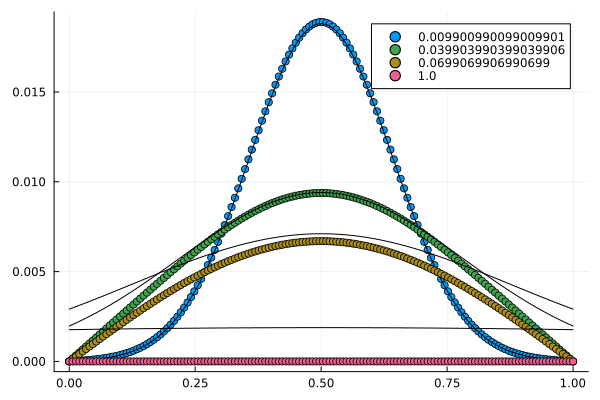

In [9]:
plot_array(u_res_absorbing, u_an_unbounded, [0.01,0.04,0.07],x )


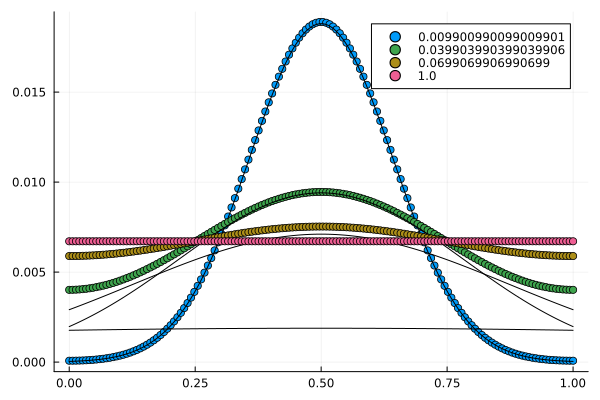

In [10]:
plot_array(u_res_reflecting, u_an_unbounded, [0.01,0.04,0.07],x )

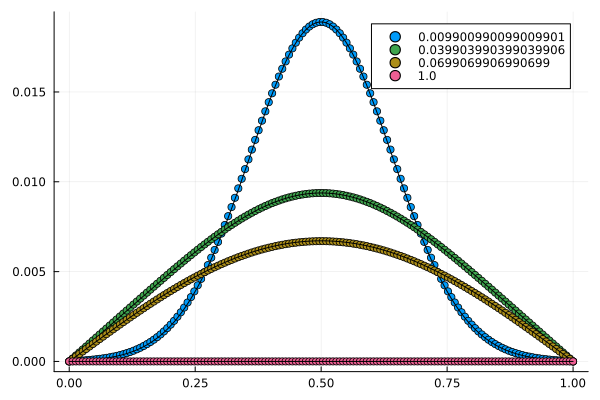

In [11]:
plot_array(u_res_absorbing, u_an_absorbing, [0.01,0.04,0.07],x )

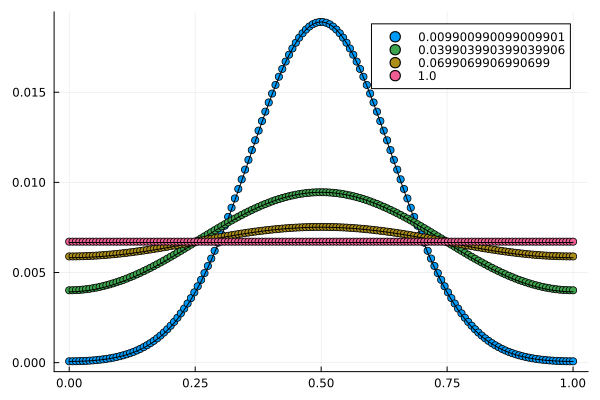

In [12]:
plot_array(u_res_reflecting, u_an_reflecting, [0.01,0.04,0.07],x )

In [13]:
function variable_alpha(x::Float64,x_boundary::Float64)
    
    if x <= x_boundary
        return D_left*dt*spacesteps^2/L^2
    else x > x_boundary
        return D_right*dt*spacesteps^2/L^2
    end
end

function make_diagonals(alpha::Vector{Float64}; method ='a')
    
    if method == 'a'
        n_steps = spacesteps-2
        
        LDA = zeros(n_steps-1)-alpha[2:end-2]/2
        MDA = ones(n_steps) + alpha[2:end-1]/2 + alpha[3:end]/2
        UDA = zeros(n_steps-1)-alpha[3:end-1]/2

        LDB = zeros(n_steps-1)+alpha[2:end-2]/2
        MDB = ones(n_steps) - alpha[2:end-1]/2 - alpha[3:end]/2
        UDB = zeros(n_steps-1)+alpha[3:end-1]/2
    end

    if method == 'r'
        n_steps = spacesteps
        LDA = zeros(n_steps-1)-alpha[1:end-1]/2
        MDA = ones(n_steps) +  alpha[1:end]/2 + reduce(vcat, [alpha[2:end]/2, alpha[end]/2])
        UDA = zeros(n_steps-1)-alpha[2:end]/2

        LDA[end]+= -alpha[end]/2
        UDA[1]  += -alpha[1]/2

        LDB = zeros(n_steps-1)+alpha[1:end-1]/2
        MDB = ones(n_steps) - alpha[1:end]/2 - reduce(vcat, [alpha[2:end]/2, alpha[end]/2])
        UDB = zeros(n_steps-1)+alpha[2:end]/2
        
        LDB[end]+= alpha[end]/2
        UDB[1]  += alpha[1]/2
    end

    return LDA, MDA, UDA, LDB, MDB, UDB
end

function absorbing_var(u_init::Vector{Float64}, alphas::Vector{Float64})

    n_steps = spacesteps - 2
   
    LDA, MDA, UDA, LDB, MDB, UDB = make_diagonals(alphas)
    
    A = Tridiagonal(LDA, MDA, UDA)

    B = Tridiagonal(LDB, MDB, UDB)


    res = Array{Array{Float64, 1}, 1}(undef, timesteps)
    res[1] = u_init
    for n in 1:timesteps-1
        res[n+1] = reduce(vcat, [0, Crank_Nicolson_step(A,B,res[n][2:end-1]),0])
    end
    return res
end 

function reflecting_var(u_init::Vector{Float64}, alphas::Vector{Float64})
    #A * U_n+1 = B * U_n
    n_steps = spacesteps
   
    LDA, MDA, UDA, LDB, MDB, UDB = make_diagonals(alphas; method = 'r')
    
    A = Tridiagonal(LDA, MDA, UDA)

    B = Tridiagonal(LDB, MDB, UDB)


    res = Array{Array{Float64, 1}, 1}(undef, timesteps)
    res[1] = u_init
    for i in 2:timesteps
        res[i] = Crank_Nicolson_step(A,B,res[i-1])
    end
    return res
end



reflecting_var (generic function with 1 method)

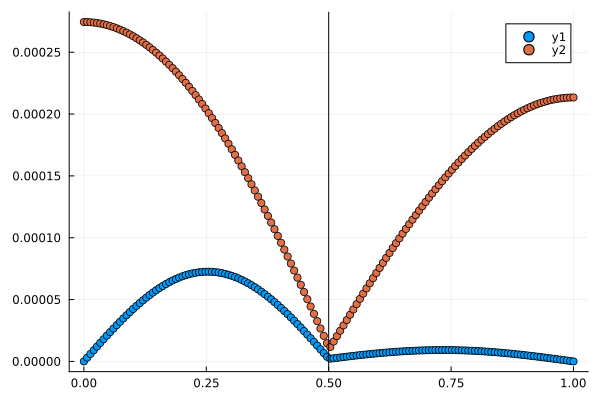

In [19]:

x = reduce(vcat, [0, cumsum(fill(L/(spacesteps-1), spacesteps-1))])
t = LinRange(0,endtime, timesteps)

u_init = zeros(spacesteps)
u_init[div(spacesteps, 2)] = u0/2
u_init[div(spacesteps, 2)+1] = u0/2

alphas = variable_alpha.(x,L/2)
absorbing_variable_D = absorbing_var(u_init, alphas)
reflecting_variable_D = reflecting_var(u_init, alphas)

plot(scatter(x,absorbing_variable_D[round(Int, 0.07/dt)]))
plot(scatter!(x,reflecting_variable_D[round(Int, 0.07/dt)]))
vline!([0.5],color ="black", label="")
